In [ ]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


image_dir = Path(r'D:\DYPLOMA\datasets\images\tiles\train')  
label_dir = Path(r'D:\DYPLOMA\datasets\labels\tiles\train')  
class_names = [
    "Fixed-wing Aircraft", "Small Aircraft", "Cargo Plane", "Helicopter", "Passenger Vehicle", 
    "Small Car", "Bus", "Pickup Truck", "Utility Truck", "Truck", "Cargo Truck", "Truck w/Box",
    "Truck Tractor", "Trailer", "Truck w/Flatbed", "Truck w/Liquid", "Crane Truck", "Railway Vehicle",
    "Passenger Car", "Cargo Car", "Flat Car", "Tank car", "Locomotive", "Maritime Vessel", "Motorboat",
    "Sailboat", "Tugboat", "Barge", "Fishing Vessel", "Ferry", "Yacht", "Container Ship", "Oil Tanker",
    "Engineering Vehicle", "Tower crane", "Container Crane", "Reach Stacker", "Straddle Carrier",
    "Mobile Crane", "Dump Truck", "Haul Truck", "Scraper/Tractor", "Front loader/Bulldozer", "Excavator",
    "Cement Mixer", "Ground Grader", "Hut/Tent", "Shed", "Building", "Aircraft Hangar", "Damaged Building",
    "Facility", "Construction Site", "Vehicle Lot", "Helipad", "Storage Tank", "Shipping container lot",
    "Shipping Container", "Pylon", "Tower"
]

def plot_image_with_boxes(img_path, lbl_path, class_names, img_size=(1024, 1024)):

    img = Image.open(img_path)
    width, height = img.size

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    with open(lbl_path, 'r') as f:
        for line in f:

            class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split())
            class_id = int(class_id)
            
            x_center *= width
            y_center *= height
            bbox_width *= width
            bbox_height *= height

            x_min = x_center - bbox_width / 2
            y_min = y_center - bbox_height / 2

            rect = patches.Rectangle((x_min, y_min), bbox_width, bbox_height, linewidth=1, 
                                     edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            
            # ax.text(x_min, y_min - 5, class_names[class_id], color='yellow', fontsize=8, 
            #         bbox=dict(facecolor='black', alpha=0.5))

    plt.axis('off')
    plt.show()

image_files = list(image_dir.glob('*.tif')) 
for img_path in image_files[:5]: 
    # img_path = r"D:\DYPLOMA\datasets\images\tiles\train\5_1920_2560.tif"
    print(img_path)
    lbl_path = label_dir / img_path.with_suffix('.txt').name
    if lbl_path.exists(): 
        plot_image_with_boxes(img_path, lbl_path, class_names)
        plt.show()
    else:
        print(f"Немає анотацій для {img_path.name}")


D:\DYPLOMA\datasets\images\tiles\train\5_1920_2560.tif


AttributeError: 'str' object has no attribute 'with_suffix'

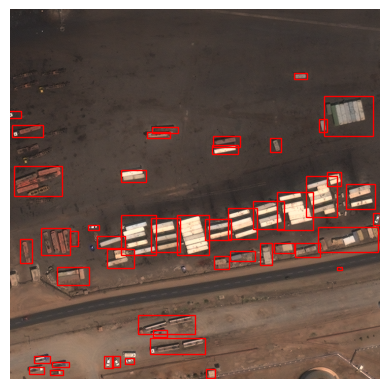

In [ ]:
img_path = Path(r"D:\DYPLOMA\datasets\images\tiles\train\5_1920_1920.tif")

lbl_path = label_dir / img_path.with_suffix('.txt').name

if lbl_path.exists():
    plot_image_with_boxes(img_path, lbl_path, class_names)
    plt.show()
else:
    print(f"Немає анотацій для {img_path.name}")


In [ ]:
import os
from pathlib import Path
from PIL import Image
import numpy as np

input_img_dir = Path(r'D:\DYPLOMA\datasets\datasets\xView\images\train') 
input_lbl_dir = Path(r'D:\DYPLOMA\datasets\datasets\xView\labels\train') 
output_img_dir = Path(r'D:\DYPLOMA\datasets\datasets\images\tiles\train')
output_lbl_dir = Path(r'D:\DYPLOMA\datasets\datasets\labels\tiles\train')
tile_size = 640  

output_img_dir.mkdir(parents=True, exist_ok=True)
output_lbl_dir.mkdir(parents=True, exist_ok=True)

def adjust_bbox(bbox, x_offset, y_offset, tile_size):
    x_center, y_center, width, height = bbox
    x_center = (x_center - x_offset) / tile_size
    y_center = (y_center - y_offset) / tile_size
    width = width / tile_size
    height = height / tile_size
    return x_center, y_center, width, height

def split_image(image_path, label_path, output_img_dir, output_lbl_dir, tile_size=640):
    img = Image.open(image_path)
    img_width, img_height = img.size
    base_name = image_path.stem

    bboxes = []
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height
                bboxes.append((class_id, x_center, y_center, width, height))

    for i in range(0, img_width, tile_size):
        for j in range(0, img_height, tile_size):
            box = (i, j, min(i + tile_size, img_width), min(j + tile_size, img_height))
            tile = img.crop(box)

            tile_name = f"{base_name}_{i}_{j}.jpg"
            tile_path = output_img_dir / tile_name
            tile.save(tile_path)

            tile_bboxes = []
            for class_id, x_center, y_center, width, height in bboxes:
                if (i <= x_center <= i + tile_size) and (j <= y_center <= j + tile_size):
                    x_tile, y_tile, w_tile, h_tile = adjust_bbox(
                        (x_center, y_center, width, height), i, j, tile_size
                    )
                    tile_bboxes.append((class_id, x_tile, y_tile, w_tile, h_tile))

            if tile_bboxes:
                label_tile_path = output_lbl_dir / tile_name.replace('.jpg', '.txt')
                with open(label_tile_path, 'w') as f:
                    for class_id, x_tile, y_tile, w_tile, h_tile in tile_bboxes:
                        f.write(f"{int(class_id)} {x_tile:.6f} {y_tile:.6f} {w_tile:.6f} {h_tile:.6f}\n")

for img_file in input_img_dir.glob('*.jpg'):
    lbl_file = input_lbl_dir / img_file.with_suffix('.txt').name
    split_image(img_file, lbl_file, output_img_dir, output_lbl_dir, tile_size)


In [ ]:
import os

output_img_dir = Path(r'D:\DYPLOMA\datasets\images\tiles\train')
output_lbl_dir = Path(r'D:\DYPLOMA\datasets\labels\tiles\train')

for label_path in output_lbl_dir.glob('*.txt'):
    if label_path.stat().st_size == 0: 
        label_path.unlink()
        
        img_path = output_img_dir / label_path.with_suffix('.tif').name
        if img_path.exists():
            img_path.unlink()

print("Порожні анотації та відповідні зображення видалено.")


Порожні анотації та відповідні зображення видалено.


In [ ]:
from pathlib import Path

output_img_dir = Path(r'D:\DYPLOMA\datasets\images\tiles\train')
output_lbl_dir = Path(r'D:\DYPLOMA\datasets\labels\tiles\train')

for img_path in output_img_dir.glob('*.tif'):
    label_path = output_lbl_dir / img_path.with_suffix('.txt').name
    if not label_path.exists():
        img_path.unlink()

print("Зображення без анотацій видалено.")


Зображення без анотацій видалено.


In [ ]:
import os
from pathlib import Path
from PIL import Image


image_dir = Path(r'D:\DYPLOMA\datasets\images\tiles\train')
label_dir = Path(r'D:\DYPLOMA\datasets\labels\tiles\train')

for img_path in image_dir.glob('*.tif'):
 
    with Image.open(img_path) as img:
        width, height = img.size
        
        if width != 640 or height != 640:
            print(f"Видалення зображення: {img_path.name} (Розмір: {width}x{height})")
            
            os.remove(img_path)
            
            lbl_path = label_dir / img_path.with_suffix('.txt').name
            if lbl_path.exists():
                os.remove(lbl_path)
                print(f"Видалено файл анотацій: {lbl_path.name}")


In [ ]:
import os
from pathlib import Path
import shutil
import random

image_dir = Path(r"D:\DYPLOMA\datasets\images\tiles\train")
label_dir = Path(r"D:\DYPLOMA\datasets\labels\tiles\train")

train_image_dir = Path(r"D:\DYPLOMA\datasets\New_dataset\xView\images\train")
val_image_dir = Path(r"D:\DYPLOMA\datasets\New_dataset\xView\images\val")
train_label_dir = Path(r"D:\DYPLOMA\datasets\New_dataset\xView\labels\train")
val_label_dir = Path(r"D:\DYPLOMA\datasets\New_dataset\xView\labels\val")

train_image_dir.mkdir(parents=True, exist_ok=True)
val_image_dir.mkdir(parents=True, exist_ok=True)
train_label_dir.mkdir(parents=True, exist_ok=True)
val_label_dir.mkdir(parents=True, exist_ok=True)

image_files = list(image_dir.glob('*.tif'))

random.shuffle(image_files)
train_files = image_files[:int(0.9 * len(image_files))]
val_files = image_files[int(0.9 * len(image_files)):]

def move_files(files, src_image_dir, src_label_dir, dest_image_dir, dest_label_dir):
    for img_path in files:

        dest_img_path = dest_image_dir / img_path.name
        shutil.move(img_path, dest_img_path)
        
        label_file = src_label_dir / img_path.with_suffix('.txt').name
        if label_file.exists():
            dest_label_path = dest_label_dir / label_file.name
            shutil.move(label_file, dest_label_path)

move_files(train_files, image_dir, label_dir, train_image_dir, train_label_dir)
move_files(val_files, image_dir, label_dir, val_image_dir, val_label_dir)

print(f"Перемещено {len(train_files)} изображений для тренировки и {len(val_files)} изображений для валидации.")
